In [ ]:
# ==============================
# IMPORTS
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
# ==============================
# 1. LOAD DATA
# ==============================
df = pd.read_csv("HepatitisCdata.csv")

print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head())
print("\nInfo:\n")
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nStatistical summary of numerical columns:\n")
print(df.describe().T)
print("\nUnique values per column:\n", df.nunique())


Shape of dataset: (615, 14)

Column names:
 ['Unnamed: 0', 'Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']

First 5 rows:
    Unnamed: 0       Category  Age Sex   ALB   ALP   ALT   AST   BIL    CHE  \
0           1  0=Blood Donor   32   m  38.5  52.5   7.7  22.1   7.5   6.93   
1           2  0=Blood Donor   32   m  38.5  70.3  18.0  24.7   3.9  11.17   
2           3  0=Blood Donor   32   m  46.9  74.7  36.2  52.6   6.1   8.84   
3           4  0=Blood Donor   32   m  43.2  52.0  30.6  22.6  18.9   7.33   
4           5  0=Blood Donor   32   m  39.2  74.1  32.6  24.8   9.6   9.15   

   CHOL   CREA   GGT  PROT  
0  3.23  106.0  12.1  69.0  
1  4.80   74.0  15.6  76.5  
2  5.20   86.0  33.2  79.3  
3  4.74   80.0  33.8  75.7  
4  4.32   76.0  29.9  68.7  

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      ------------

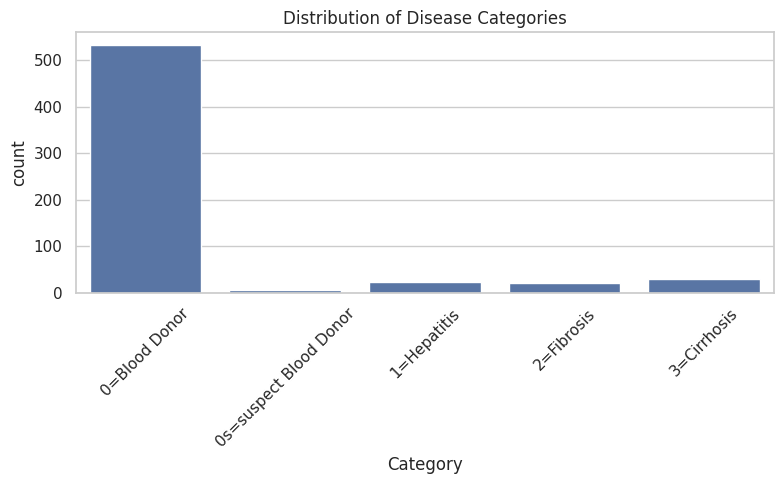

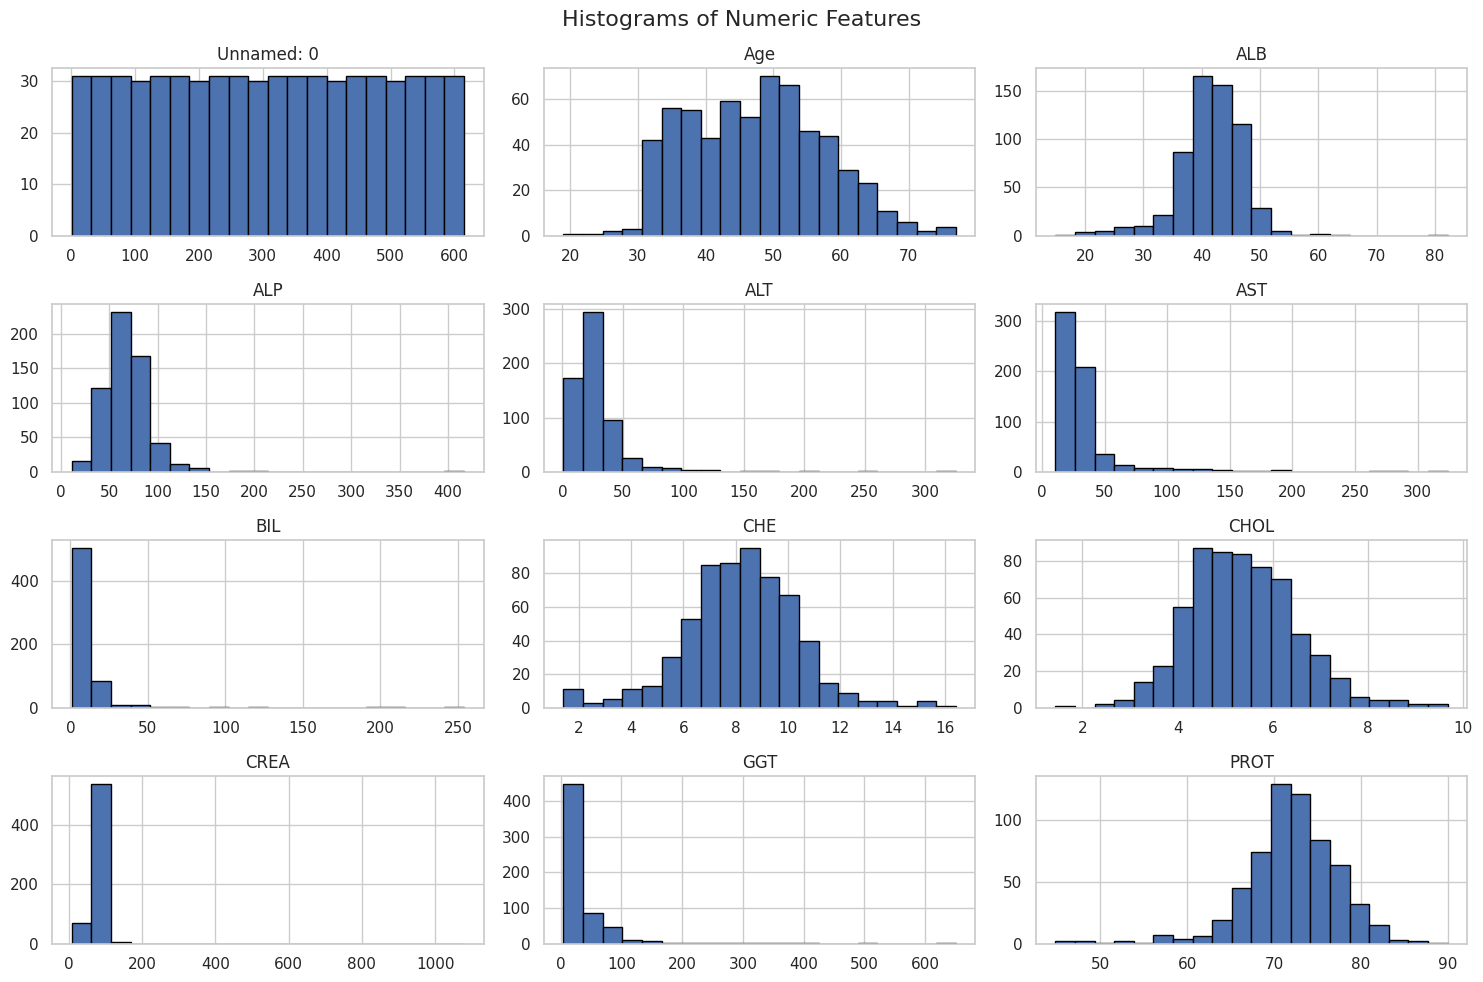

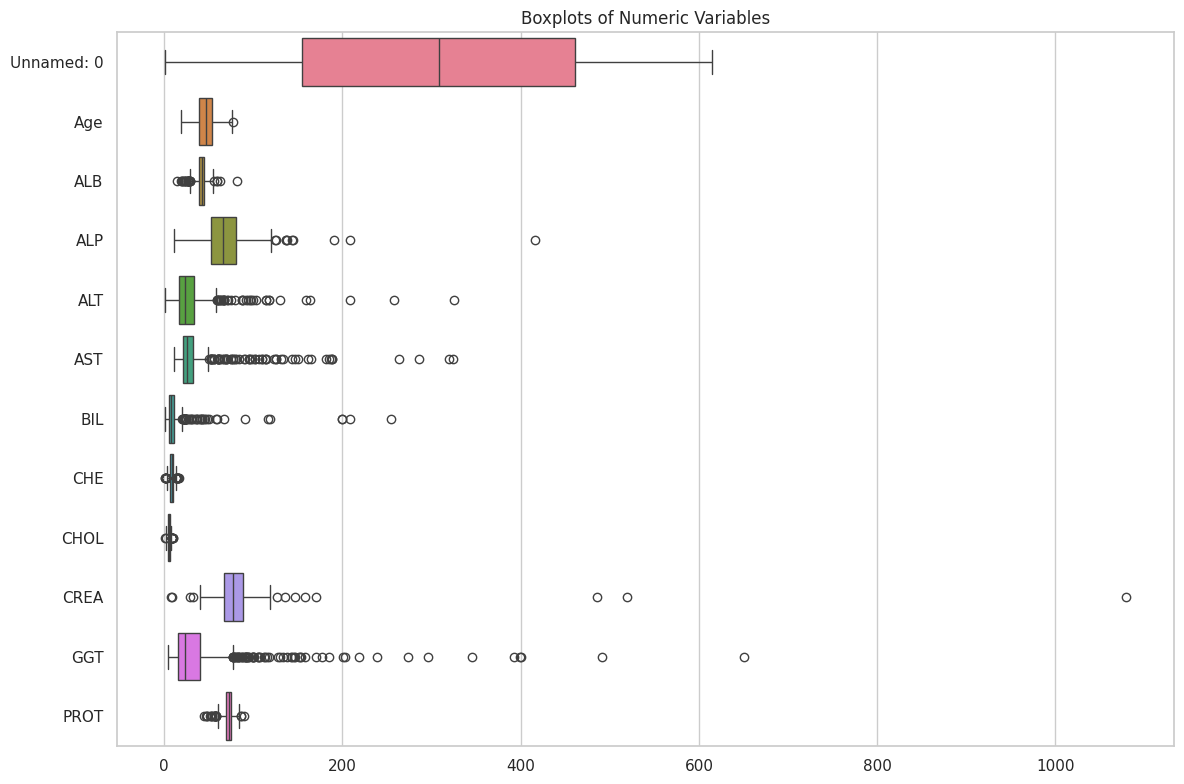

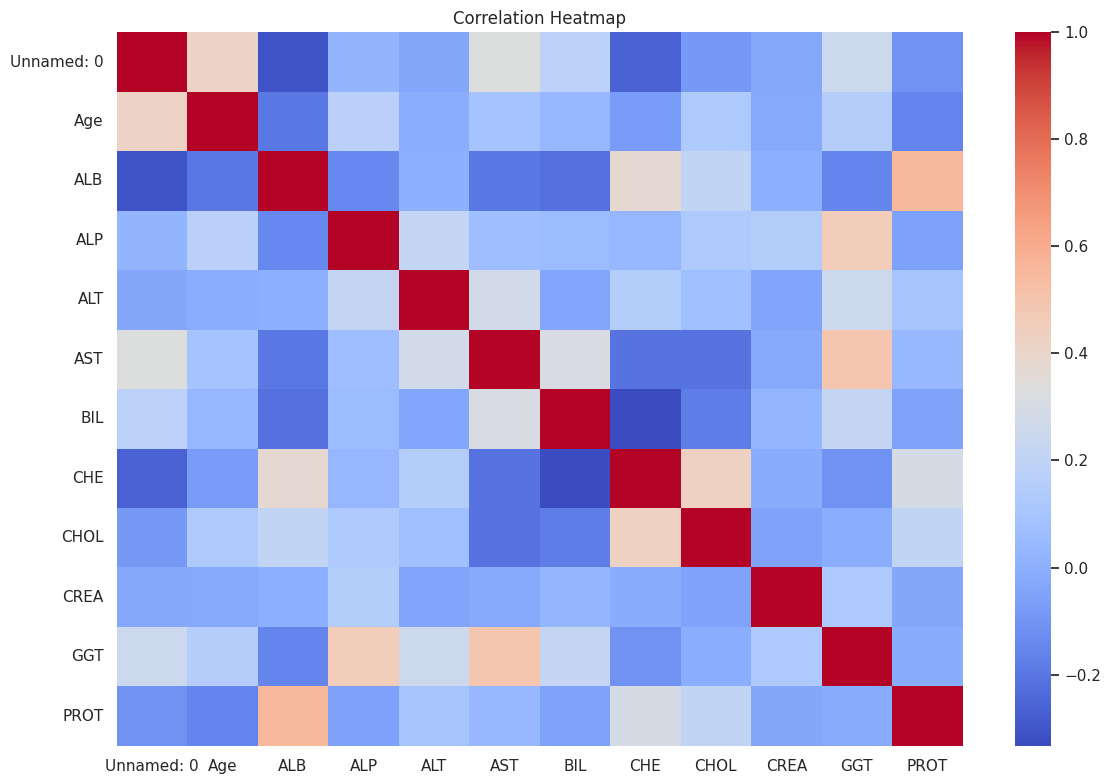

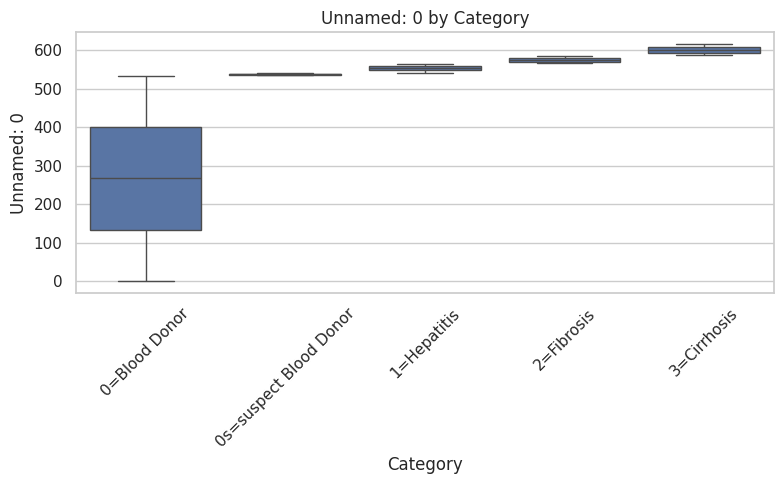

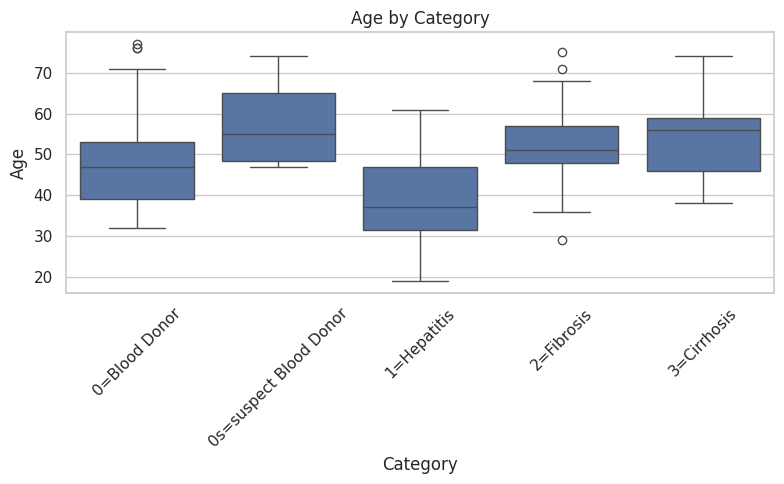

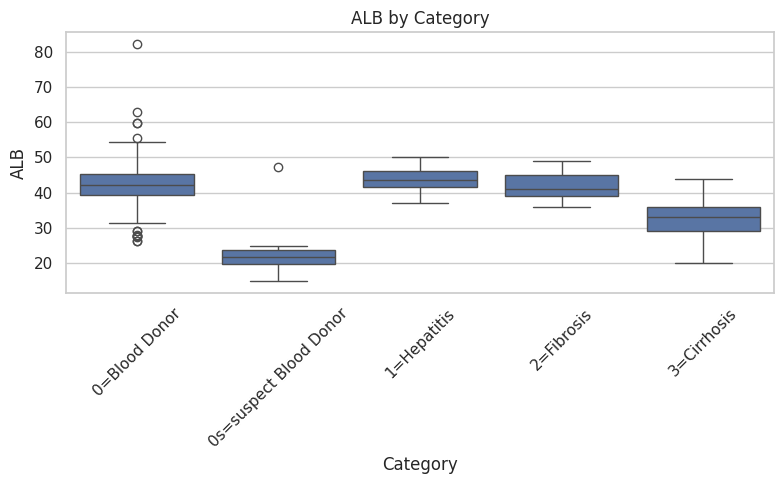

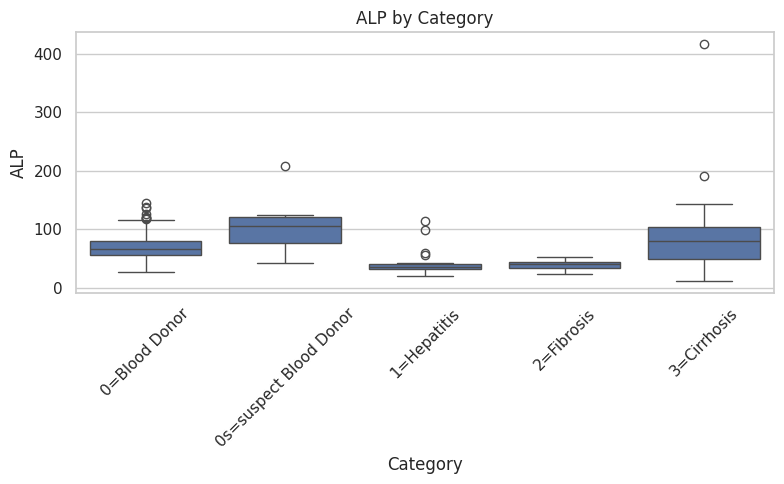

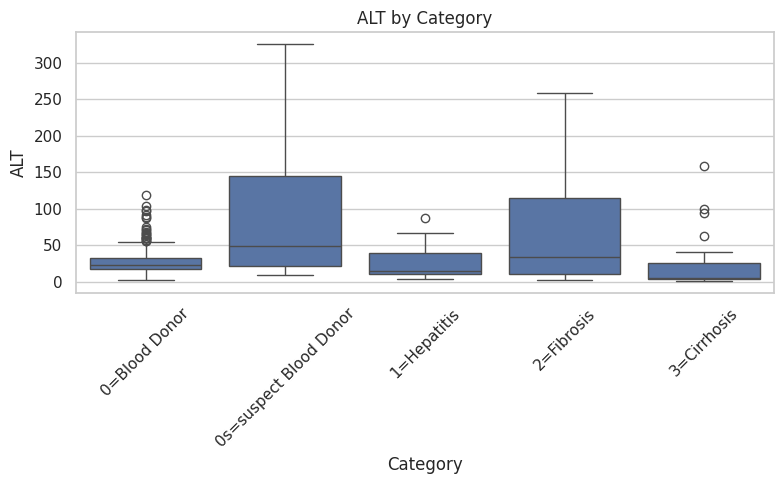

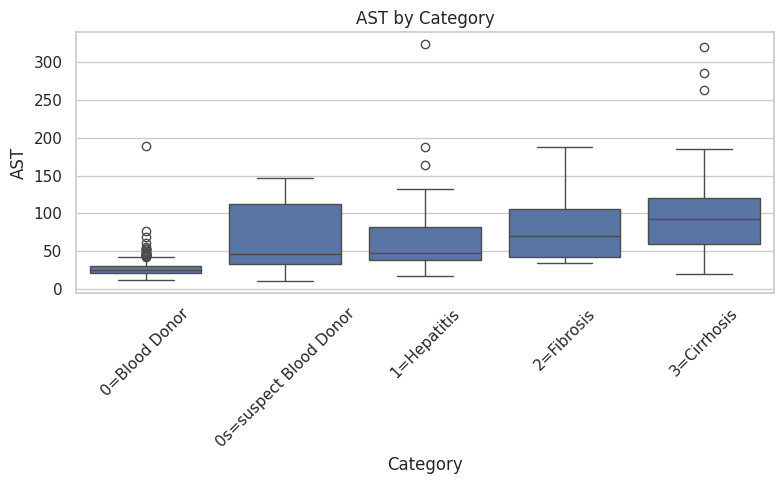

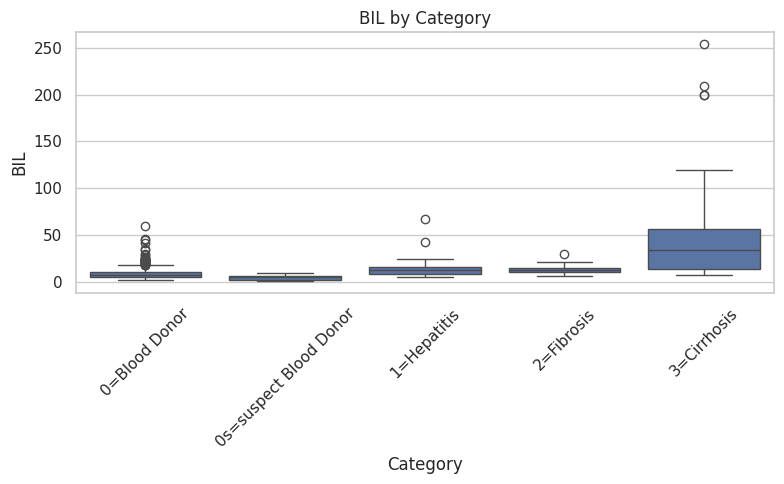

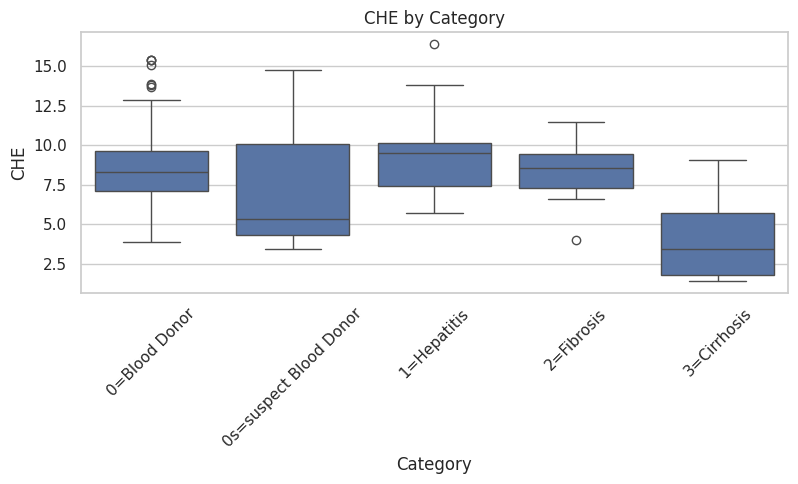

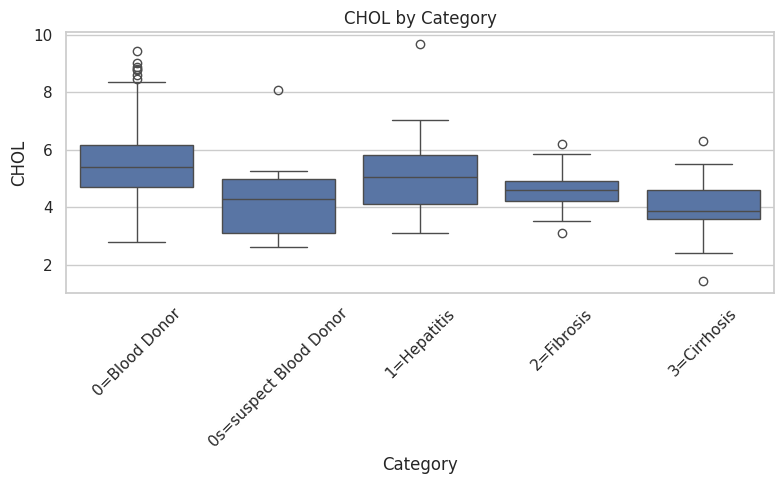

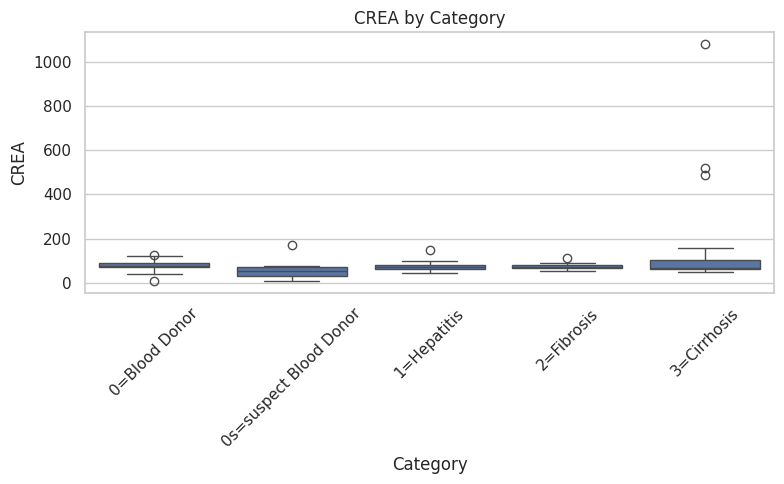

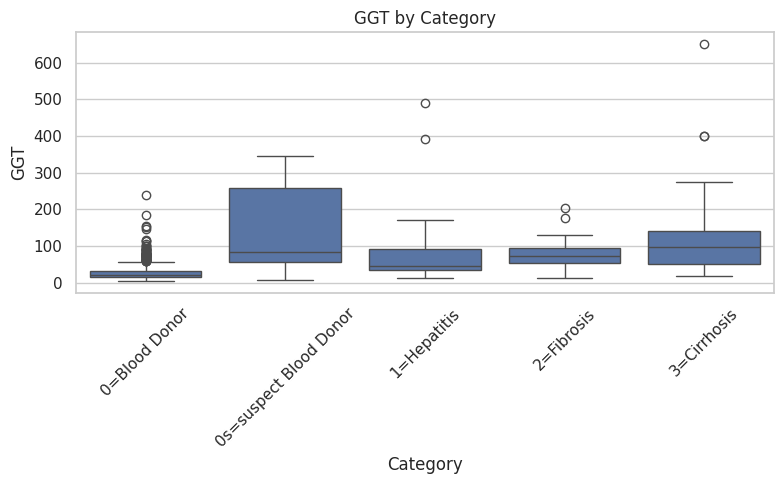

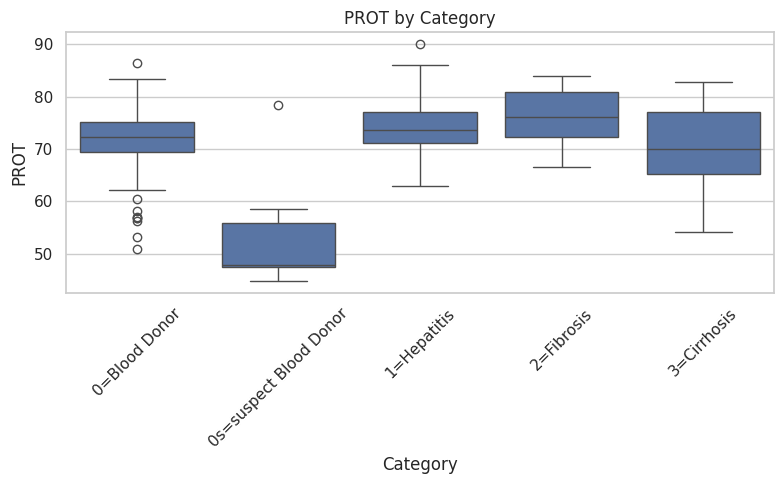

In [ ]:
# ==============================
# 2. EDA
# ==============================
sns.set(style="whitegrid")

# Target distribution (original string labels, before encoding)
if "Category" in df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x="Category")
    plt.title("Distribution of Disease Categories")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Histograms of numeric features
num_cols = df.select_dtypes(include=np.number).columns
if len(num_cols) > 0:
    df[num_cols].hist(figsize=(15, 10), bins=20, edgecolor="black")
    plt.suptitle("Histograms of Numeric Features", fontsize=16)
    plt.tight_layout()
    plt.show()

# Boxplots for numeric features
if len(num_cols) > 0:
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df[num_cols], orient="h")
    plt.title("Boxplots of Numeric Variables")
    plt.tight_layout()
    plt.show()

# Correlation heatmap
if len(num_cols) > 1:
    plt.figure(figsize=(12, 8))
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=False, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

# numeric distributions by Category
if "Category" in df.columns and len(num_cols) > 0:
    for col in num_cols:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df, x="Category", y=col)
        plt.title(f"{col} by Category")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
# ==============================
# 3. PREPROCESSING FOR MODELING
# ==============================

# Drop ID column if present
if "ID" in df.columns:
    df = df.drop("ID", axis=1)

# Check target
if "Category" not in df.columns:
    raise ValueError("No 'Category' column found in dataset!")

# Encode target variable
le_target = LabelEncoder()
df["Category"] = le_target.fit_transform(df["Category"])
print("\nTarget label encoding:")
for i, c in enumerate(le_target.classes_):
    print(f"{i} -> {c}")

# Encode non-numeric features (excluding target)
non_numeric_cols = df.drop("Category", axis=1).select_dtypes(include=["object"]).columns.tolist()
if len(non_numeric_cols) > 0:
    print("\nEncoding non-numeric feature columns:", non_numeric_cols)
    for col in non_numeric_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
else:
    print("\nNo non-numeric feature columns found.")

# Separate features and target
X = df.drop("Category", axis=1)
y = df["Category"]

print("\nClass distribution (full data):", Counter(y))
feature_names = X.columns.tolist()

# We will impute inside pipelines to avoid leakage, but check for NAs now:
print("\nMissing values in X before pipeline imputation:\n", X.isnull().sum())
print("Missing values in y:", y.isnull().sum())


Target label encoding:
0 -> 0=Blood Donor
1 -> 0s=suspect Blood Donor
2 -> 1=Hepatitis
3 -> 2=Fibrosis
4 -> 3=Cirrhosis

Encoding non-numeric feature columns: ['Sex']

Class distribution (full data): Counter({0: 533, 4: 30, 2: 24, 3: 21, 1: 7})

Missing values in X before pipeline imputation:
 Unnamed: 0     0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL            0
CHE            0
CHOL          10
CREA           0
GGT            0
PROT           1
dtype: int64
Missing values in y: 0


In [ ]:
# ==============================
# 4. CV STRATEGY
# ==============================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# ==============================
# 5. DEFINE MODELS + PIPELINES + PARAM GRIDS
# ==============================
models = {
    "Logistic Regression": {
        "pipeline": Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                max_iter=2000,
                class_weight="balanced",
                multi_class="auto",
                random_state=42
            ))
        ]),
        "param_grid": {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__solver": ["lbfgs", "liblinear"]
        }
    },

    "Decision Tree": {
        "pipeline": Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", DecisionTreeClassifier(
                class_weight="balanced",
                random_state=42
            ))
        ]),
        "param_grid": {
            "clf__max_depth": [3, 5, 10, None],
            "clf__min_samples_split": [2, 5, 10],
            "clf__criterion": ["gini", "entropy"]
        }
    },

    "Random Forest": {
        "pipeline": Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", RandomForestClassifier(
                class_weight="balanced",
                random_state=42
            ))
        ]),
        "param_grid": {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_split": [2, 5]
        }
    },

    "Gradient Boosting": {
        # GradientBoostingClassifier does not support class_weight directly
        "pipeline": Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", GradientBoostingClassifier(random_state=42))
        ]),
        "param_grid": {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.01, 0.1],
            "clf__max_depth": [2, 3]
        }
    }
}

In [ ]:
# ==============================
# 6. EVALUATION FUNCTION (CROSS-VAL)
# ==============================
def evaluate_with_cv(model_name, pipeline, param_grid, X, y, cv):
    print("\n" + "=" * 70)
    print(f"Tuning & evaluating: {model_name}")
    print("=" * 70)

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1
    )

    grid.fit(X, y)
    best_model = grid.best_estimator_

    print("Best params:", grid.best_params_)
    print(f"Best CV F1 (macro): {grid.best_score_:.4f}")

    # Cross-validated predictions with the best model
    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average="macro", zero_division=0)
    rec = recall_score(y, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y, y_pred, average="macro", zero_division=0)

    print("\n==== Cross-validated performance on full dataset ====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    print("\nClassification report:\n")
    print(classification_report(y, y_pred, target_names=le_target.classes_))

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", cbar=False,
        xticklabels=le_target.classes_,
        yticklabels=le_target.classes_
    )
    plt.title(f"{model_name} - Confusion Matrix (CV predictions)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return {
        "best_params": grid.best_params_,
        "cv_f1_macro": grid.best_score_,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1
    }



Tuning & evaluating: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Best params: {'clf__C': 0.1, 'clf__solver': 'liblinear'}
Best CV F1 (macro): 0.7694

==== Cross-validated performance on full dataset ====
Accuracy : 0.9610
Precision: 0.7991
Recall   : 0.7978
F1 Score : 0.7971

Classification report:

                        precision    recall  f1-score   support

         0=Blood Donor       1.00      1.00      1.00       533
0s=suspect Blood Donor       0.86      0.86      0.86         7
           1=Hepatitis       0.69      0.75      0.72        24
            2=Fibrosis       0.57      0.62      0.59        21
           3=Cirrhosis       0.88      0.77      0.82        30

              accuracy                           0.96       615
             macro avg       0.80      0.80      0.80       615
          weighted avg       0.96      0.96      0.96       615



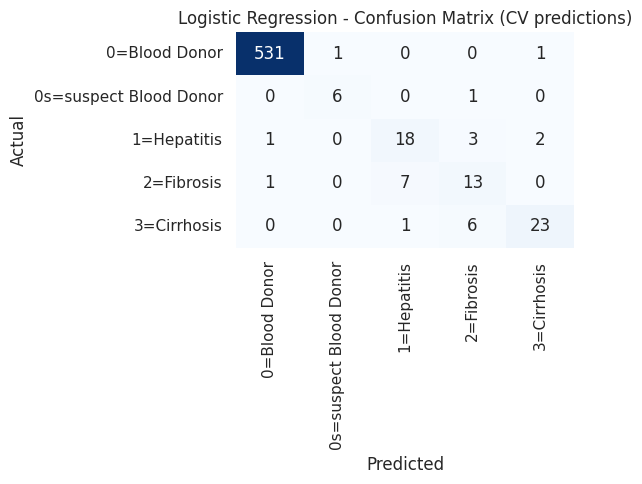


Tuning & evaluating: Decision Tree
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_split': 2}
Best CV F1 (macro): 0.9606

==== Cross-validated performance on full dataset ====
Accuracy : 0.9951
Precision: 0.9620
Recall   : 0.9564
F1 Score : 0.9589

Classification report:

                        precision    recall  f1-score   support

         0=Blood Donor       1.00      1.00      1.00       533
0s=suspect Blood Donor       0.86      0.86      0.86         7
           1=Hepatitis       1.00      0.96      0.98        24
            2=Fibrosis       0.95      1.00      0.98        21
           3=Cirrhosis       1.00      0.97      0.98        30

              accuracy                           1.00       615
             macro avg       0.96      0.96      0.96       615
          weighted avg       1.00      1.00      1.00       615



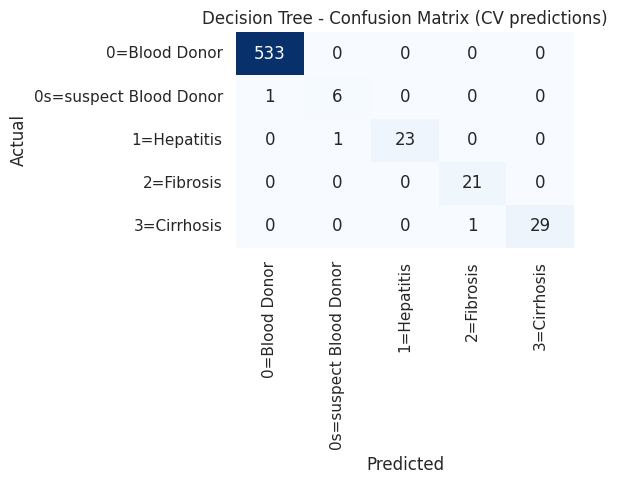


Tuning & evaluating: Random Forest
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Best CV F1 (macro): 0.8753

==== Cross-validated performance on full dataset ====
Accuracy : 0.9854
Precision: 0.9635
Recall   : 0.8652
F1 Score : 0.9025

Classification report:

                        precision    recall  f1-score   support

         0=Blood Donor       0.99      1.00      1.00       533
0s=suspect Blood Donor       1.00      0.57      0.73         7
           1=Hepatitis       0.96      0.92      0.94        24
            2=Fibrosis       0.90      0.90      0.90        21
           3=Cirrhosis       0.97      0.93      0.95        30

              accuracy                           0.99       615
             macro avg       0.96      0.87      0.90       615
          weighted avg       0.99      0.99      0.98       615



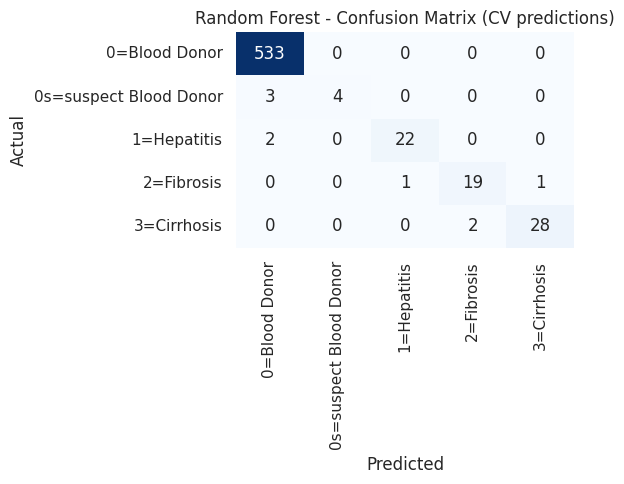


Tuning & evaluating: Gradient Boosting
Best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 200}
Best CV F1 (macro): 0.9336

==== Cross-validated performance on full dataset ====
Accuracy : 0.9935
Precision: 0.9898
Recall   : 0.9279
F1 Score : 0.9538

Classification report:

                        precision    recall  f1-score   support

         0=Blood Donor       0.99      1.00      1.00       533
0s=suspect Blood Donor       1.00      0.71      0.83         7
           1=Hepatitis       1.00      0.96      0.98        24
            2=Fibrosis       0.95      1.00      0.98        21
           3=Cirrhosis       1.00      0.97      0.98        30

              accuracy                           0.99       615
             macro avg       0.99      0.93      0.95       615
          weighted avg       0.99      0.99      0.99       615



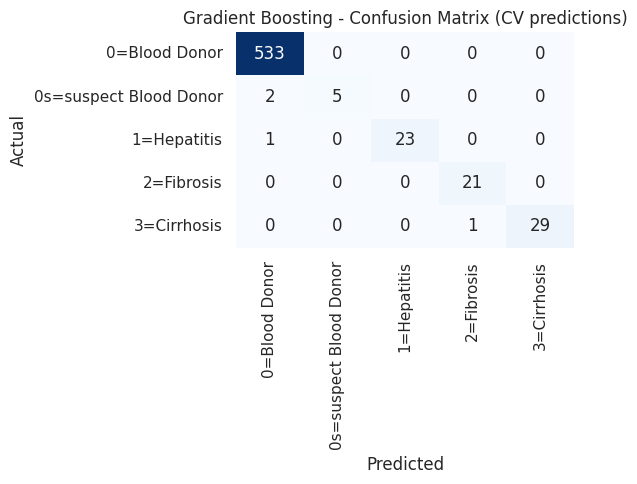

In [ ]:
# ==============================
# 7. RUN ALL MODELS
# ==============================
all_results = {}

for name, cfg in models.items():
    res = evaluate_with_cv(
        model_name=name,
        pipeline=cfg["pipeline"],
        param_grid=cfg["param_grid"],
        X=X,
        y=y,
        cv=cv
    )
    all_results[name] = res

In [ ]:
# ==============================
# 8. SUMMARY
# ==============================
print("\n\n================ FINAL CROSS-VALIDATED PERFORMANCE SUMMARY ================")
for m, r in all_results.items():
    print(f"\n📌 {m}")
    print(" Best params:", r["best_params"])
    print(f" CV F1 (macro, GridSearch) : {r['cv_f1_macro']:.4f}")
    print(f" Accuracy (cv-predictions) : {r['acc']:.4f}")
    print(f" Precision (macro)         : {r['prec']:.4f}")
    print(f" Recall (macro)            : {r['rec']:.4f}")
    print(f" F1 Score (macro)          : {r['f1']:.4f}")




================ FINAL CROSS-VALIDATED PERFORMANCE SUMMARY ================

📌 Logistic Regression
 Best params: {'clf__C': 0.1, 'clf__solver': 'liblinear'}
 CV F1 (macro, GridSearch) : 0.7694
 Accuracy (cv-predictions) : 0.9610
 Precision (macro)         : 0.7991
 Recall (macro)            : 0.7978
 F1 Score (macro)          : 0.7971

📌 Decision Tree
 Best params: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_split': 2}
 CV F1 (macro, GridSearch) : 0.9606
 Accuracy (cv-predictions) : 0.9951
 Precision (macro)         : 0.9620
 Recall (macro)            : 0.9564
 F1 Score (macro)          : 0.9589

📌 Random Forest
 Best params: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
 CV F1 (macro, GridSearch) : 0.8753
 Accuracy (cv-predictions) : 0.9854
 Precision (macro)         : 0.9635
 Recall (macro)            : 0.8652
 F1 Score (macro)          : 0.9025

📌 Gradient Boosting
 Best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 